In [1]:
import os
import warnings
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed 
from sklearn import ensemble, linear_model, svm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from test_diff_models import *
from success_utils import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create a dictionary to group countries by region
region_groups = {
    "North America": ["HI", "Mexico", "NV", "OK", "NM","CA", "NY", "MD", "DC", "WA", "CO", "MN", "TX", "SC", "GA", "KY", "PA", "MI", "OH", "OR", "NC", "IL", "AZ", "TN", "NJ", "UT", "VA", "ND", "VT", "IA", "ND", "VT", "LA", "CT", "RI"],
    "Europe": ["Martinique", "AL", "Cayman Islands", "Russia", "ME", "UK", "DE", "Poland", "Denmark", "Netherlands", "Norway", "Liechtenstein", "Austria", "Belgium", "Czech Republic", "Iceland", "Ireland", "France", "Spain", "Sweden", "Switzerland", "Italy", "Slovenia", "Greece"],
    "Asia": ["MO", "IN", "Japan", "China", "Hong Kong", "India", "Viet Nam", "Taiwan", "Afghanistan", "Israel","Sri Lanka", "Jordan"],
    "South America": ["Colombia", "Brazil"],
    "Africa": ["WI", "SD", "MA", "Ghana", "Ethiopia", "Liberia", "Rwanda"],
    "Oceania": ["AU", "NZ"],
    "Other": [ "United Arab Emirates", "Svalbard and Jan Mayen"]
}

noticable_entities = ['ORG', 'PERSON', 'DATE',
                        'CARDINAL', 'GPE', 'PRODUCT', 
                        'WORK_OF_ART','ORDINAL', 'MONEY',
                        'TIME', 'NORP']


data_path = '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/Kickstarter_only/final_data.csv'
success_data = pd.read_csv(data_path)
success_data['collection_ratio'] = success_data.collected.apply(decode_amount)/success_data.goal_amount.apply(decode_amount)


bins = [0, 7, 14, 30, 60]
labels = ['<1 week', '1-2 weeks', '2 weeks - 1 month', '1-2 months']
success_data['duration'] = pd.cut(success_data['duration'], bins=bins, labels=labels)
success_data= success_data[success_data.donate != 1].reset_index(drop=True)


success_weights = (1-success_data.success.value_counts()/len(success_data)).values


def get_region(country):
    for region, countries in region_groups.items():
        if country in countries:
            return region
    return "Other"

success_data['region'] = success_data.country.str.strip().apply(get_region)
success_data.num_backers = success_data.num_backers.str.replace(',', '').astype(int)
success_data = success_data[success_data.region == 'North America']

success_data = pd.get_dummies(
                    success_data,
                    columns=['fb_type', 
                              'duration'])


for entity in noticable_entities:
    success_data[f'fb_entity_{entity}'] = success_data.fb_entities_identified.fillna('None').str.split(',').apply(lambda entity_list: entity in entity_list).astype(int)
    

bool_cols = success_data.dtypes[success_data.dtypes == 'bool'].index.tolist()
success_data[bool_cols] = success_data[bool_cols].astype(int)

#ecoding the number of backers
success_data.num_backers = encode_targets(success_data.num_backers)
success_data.population = np.exp(success_data.population)


success_data.head()

,collected,goal_amount,num_backers,category,pledge_types,donate,project_we_love,success,start_month,start_day,population,country,Person,Team,num_projects,num_backed,verified,fb_page_name,fb_likes_at_posting,fb_followers_at_posting,fb_likes,fb_comments,fb_shares,fb_post_views,fb_readability,fb_readability_lix,fb_entropy_scores,fb_perplexity_scores,fb_fear,fb_anger,fb_anticip,fb_trust,fb_surprise,fb_positive,fb_negative,fb_sadness,fb_disgust,fb_joy,fb_entities_identified,fb_post_sponsored,fb_post_age,fb_page_age,fb_positive_reactions,fb_negative_reactions,fb_topic_0,fb_topic_1,fb_topic_2,fb_topic_3,fb_topic_4,fb_topic_5,fb_topic_6,fb_topic_7,fb_topic_8,fb_topic_9,fb_topic_10,collection_ratio,region,fb_type_link,fb_type_photo,fb_type_video,duration_<1 week,duration_1-2 weeks,duration_2 weeks - 1 month,duration_1-2 months,fb_entity_ORG,fb_entity_PERSON,fb_entity_DATE,fb_entity_CARDINAL,fb_entity_GPE,fb_entity_PRODUCT,fb_entity_WORK_OF_ART,fb_entity_ORDINAL,fb_entity_MONEY,fb_entity_TIME,fb_entity_NORP
2,12.960635,10.819778,6.823286,design,4.0,0.0,1.0,1,6,1,684451.0,WA,0,1,7,16,Marc Barros,Kickstarter,1589901,1588019,10,2,1,12,4.836818,33.727273,0.719996,2.054425,0.000024,0.000011,0.000037,0.000062,0.000093,1.000000,0.000029,0.000020,0.000028,0.000062,PRODUCT,0,2,4839,2,0,0.000064,0.000036,0.000074,0.242741,0.000100,0.000050,0.450027,0.075764,0.085070,0.000038,0.116083,8.506720,North America,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,11.866416,9.903488,6.954639,comics,8.0,0.0,1.0,1,6,1,105319.0,CA,1,0,3,88,Adam Lawson,Kickstarter,1589930,1588019,4,1,0,5,6.933333,29.111111,0.625279,1.868768,0.000057,0.000018,0.000070,0.000098,0.000096,0.000032,0.000036,0.000013,0.000020,0.000074,"CARDINAL,PERSON",0,8,4839,0,1,0.000026,0.000060,0.939369,0.000080,0.000065,0.000032,0.000011,0.000050,0.000082,0.000096,0.000015,7.120150,North America,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
5,10.374272,10.308953,5.318120,film_Video,13.0,0.0,1.0,1,6,1,8175133.0,NY,1,0,1,2,Julia Greenberg,Kickstarter,1589715,1587803,3,1,0,4,15.900000,61.666667,0.284582,1.329206,0.285714,0.000047,0.000050,0.000100,0.000088,0.285714,0.142857,0.000096,0.000082,0.142857,"PERSON,GPE",0,9,4839,0,1,0.000019,0.154496,0.000084,0.081168,0.000079,0.126198,0.000052,0.156902,0.294644,0.163853,0.000095,1.067500,North America,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
6,9.542446,8.804775,5.556828,comics,16.0,0.0,1.0,1,6,1,3971883.0,CA,0,1,4,23,Donold Wooldridge,Kickstarter,1589715,1587803,3,5,1,5,14.239500,45.000000,0.570874,1.769813,0.200000,0.200000,0.000072,0.000028,0.000076,0.000049,0.400000,0.200000,0.000072,0.000036,WORK_OF_ART,0,10,4839,1,1,0.000043,0.000028,0.162778,0.000097,0.000045,0.000027,0.059113,0.062181,0.060710,0.626484,0.000060,2.091059,North America,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8,11.346304,9.210340,7.051856,games,27.0,0.0,1.0,1,6,4,621849.0,MD,1,0,5,21,Amanda Coronado,Kickstarter,1589543,1587618,9,3,1,11,3.083867,20.333333,0.466686,1.594701,0.000036,0.000051,0.000068,0.000010,0.000083,1.000000,0.000015,0.000030,0.000068,0.000067,"PERSON,CARDINAL",0,14,4839,1,1,0.000018,0.000018,0.073925,0.798958,0.000098,0.000041,0.000093,0.000046,0.000022,0.000042,0.102862,8.465200,North America,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


In [2]:
dropping_columns = ['collected', 'verified', 'donate', 'project_we_love', 'Team' ,'country', 'fb_page_name', 'region', 'fb_entities_identified', 'population', 'category']

success_data.drop(columns=dropping_columns, axis=1, inplace=True)
success_data = success_data[success_data.collection_ratio < 10].reset_index(drop=True)
success_data.pledge_types = success_data.pledge_types.astype(int)
success_data.num_projects = success_data.num_projects.astype(int)
success_data.num_backed = success_data.num_backed.astype(int)


In [3]:
#identify and list all the boolean features disguised as int in the dataset
bool_features = []
for col in success_data.columns:
    if success_data[col].nunique() == 2:
        bool_features.append(col)

bool_features.remove('success')

In [4]:
entity_features = [x for x in bool_features if 'fb_entity' in x]
duration_features = [x for x in bool_features if 'duration' in x]
region_features = [x for x in bool_features if 'region' in x]


In [5]:
# from sklearn.decomposition import PCA, TruncatedSVD
# def save_embedding_info(loadings, entity_features, name):
#     # Create a dataframe to store the loadings
#     loadings_df = pd.DataFrame(loadings, columns=entity_features)

#     plt.figure(figsize=(20, 10))
#     sns.heatmap(loadings_df, cmap='RdBu', center=0, annot=True)
#     save_path = '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/heatmaps for embeddings'
#     plt.savefig(save_path + f'/{name}.png', bbox_inches='tight')

# def try_svd(df, cols):
#     for i in range(1, len(cols)):
#         svd = TruncatedSVD(n_components=i)
#         svd.fit(df[cols])
#         evr = svd.explained_variance_ratio_.sum()
#         print(f'Explained variance ratio for {i} components: {svd.explained_variance_ratio_.sum()}')
#         if evr > 0.8:
#             return svd, i

# def append_embeddings(embeddings, df, col):
#     for i in range(embeddings.shape[1]):
#         df[f'{col}_embedding_{i}'] = embeddings[:,i]
#     return df

# svd, n_components = try_svd(success_data, entity_features)
# embddings = svd.fit_transform(success_data[entity_features])
# loadings = svd.components_
# save_embedding_info(loadings, entity_features, 'fb_entities')

# success_data = append_embeddings(embddings, success_data, 'fb_entities')

# svd, n_components = try_svd(success_data, region_features)
# embddings = svd.fit_transform(success_data[region_features])
# loadings = svd.components_
# save_embedding_info(loadings, region_features, 'region')

# success_data = append_embeddings(embddings, success_data, 'region')

# svd, n_components = try_svd(success_data, categories)
# embddings = svd.fit_transform(success_data[categories])
# loadings = svd.components_
# save_embedding_info(loadings, categories, 'categories')

# success_data = append_embeddings(embddings, success_data, 'categories')

# success_data.drop(columns=entity_features + region_features + categories, axis=1, inplace=True)

In [6]:
success_data.num_backers = np.exp(success_data.num_backers)
target_cols = [
    'success',
    'collection_ratio',
    'num_backers'
]

fb_cols = success_data.columns[success_data.columns.str.startswith('fb')].tolist()
common_features= success_data.columns[~success_data.columns.str.startswith('fb')].tolist()
common_features = [feature for feature in common_features if feature not in target_cols]

engagement_features = [ 'fb_likes', 'fb_comments', 'fb_shares','fb_positive_reactions','fb_negative_reactions']
post_fb_features = [feature for feature in fb_cols if feature not in engagement_features]


In [7]:
domain_page_features = success_data[common_features]
domain_engagement_features = success_data[common_features + engagement_features]
domain_post_features = success_data[common_features + post_fb_features]

targets = success_data[target_cols]

In [8]:
pd.concat([domain_page_features, targets], axis=1).to_csv('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_only.csv', index=False)
pd.concat([domain_engagement_features, targets], axis=1).to_csv('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_engagement.csv', index=False)
pd.concat([domain_post_features, targets], axis=1).to_csv('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv', index=False)

In [9]:
print(common_features)

['goal_amount', 'pledge_types', 'start_month', 'start_day', 'Person', 'num_projects', 'num_backed', 'duration_<1 week', 'duration_1-2 weeks', 'duration_2 weeks - 1 month', 'duration_1-2 months']


## Modelling

In [10]:
working_data = 'domain_post'
domain_post = pd.read_csv(f'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/{working_data}.csv')

In [11]:
domain_post.loc[:,target_cols].head()

,success,collection_ratio,num_backers
0,1,8.506720,919.0
1,1,7.120150,1048.0
2,1,1.067500,204.0
3,1,2.091059,259.0
4,1,8.465200,1155.0


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(domain_post.drop(target_cols, axis=1), domain_post[target_cols], test_size=0.13, random_state=42, stratify=domain_post.success)

X_train = X_train.reset_index(drop=True).values
X_test = X_test.reset_index(drop=True).values
y_train = y_train.reset_index(drop=True).values
y_test = y_test.reset_index(drop=True).values

* y[:, 0] => Success (Boolean)
* y[:,1] => Collection Ratio
* y[:,2] => Number of Backers


In [15]:
reg_test = RegressionModels(X_train, X_test, y_train[:,2], y_test[:,2], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 161.50it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
ExtraTreesRegressor,3750.456,1101.512,0.271,0.280
RandomForestRegressor,3763.696,1156.909,0.266,0.276
BaggingRegressor,3798.495,1175.641,0.252,0.260
GradientBoostingRegressor,3838.386,1191.746,0.237,0.249
AdaBoostRegressor,3844.342,1553.609,0.234,0.234
XGBRegressor,3857.998,1169.538,0.229,0.240
LinearRegression,4015.508,1303.647,0.164,0.188
KernelRidge,4016.543,1289.882,0.164,0.188
Lasso,4017.626,1288.949,0.164,0.186
LassoLars,4017.626,1288.949,0.164,0.186


In [16]:
reg_test = RegressionModels(X_train, X_test, encode_targets(y_train[:,2]), encode_targets(y_test[:,2]), decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 149.16it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
RidgeCV,0.969,0.783,0.467,0.473
LassoLarsCV,0.970,0.778,0.466,0.472
LassoLarsIC,0.972,0.783,0.464,0.470
BayesianRidge,0.973,0.778,0.463,0.469
ExtraTreesRegressor,0.986,0.787,0.448,0.455
Ridge,0.986,0.801,0.448,0.454
KernelRidge,0.992,0.802,0.442,0.449
ARDRegression,0.994,0.808,0.439,0.446
LinearRegression,0.997,0.807,0.436,0.443
RandomForestRegressor,1.004,0.800,0.427,0.430


In [ ]:
cls_test = ClassificationModels(X_train, X_test, y_train[:,0], y_test[:,0])
cls_test.run_evaluation()
print(cls_test.not_trained_)
print(cls_test.not_evaluated_)
cls_test.top_10_socres

Evaluating models: 100%|██████████| 27/27 [00:00<00:00, 80.69it/s] 

The modelsNu-Support Vector Machine could not be trained.
The modelsKernel Ridge could not be evaluated.


,Accuracy,Precision,Recall,F1 Score,ROC AUC,Class-0 Acc,Class-1 Acc
Balanced Random Forest Classifier,0.64,0.97,0.62,0.75,0.72,0.82,0.62
Gaussian Process,0.13,0.71,0.05,0.09,0.43,0.82,0.05
Gaussian Naive Bayes,0.54,0.94,0.52,0.67,0.62,0.73,0.52
Easy Ensemble Classifier,0.57,0.93,0.57,0.70,0.60,0.64,0.57
RUSBoost Classifier,0.77,0.93,0.81,0.86,0.63,0.45,0.81
Balanced Bagging Classifier,0.72,0.93,0.75,0.83,0.60,0.45,0.75
Multinomial Naive Bayes,0.63,0.88,0.68,0.77,0.43,0.18,0.68
AdaBoost,0.89,0.91,0.97,0.94,0.58,0.18,0.97
Support Vector Machine,0.90,0.90,1.00,0.95,0.50,0.00,1.00
Dummy Classifier,0.90,0.90,1.00,0.95,0.50,0.00,1.00


## Further Finetuning of the topk models

### Collection Ratio

In [24]:
reg_test = RegressionModels(X_train, X_test, y_train[:,1], y_test[:,1], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 178.04it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
GradientBoostingRegressor,1.519,1.017,0.284,0.286
ExtraTreesRegressor,1.573,1.145,0.233,0.241
RandomForestRegressor,1.595,1.176,0.211,0.211
LarsCV,1.627,1.186,0.179,0.183
LassoLarsCV,1.645,1.196,0.160,0.166
ElasticNet,1.666,1.210,0.139,0.140
RidgeCV,1.677,1.241,0.128,0.133
Lasso,1.688,1.236,0.116,0.117
LassoLars,1.688,1.236,0.116,0.117
TweedieRegressor,1.707,1.239,0.096,0.097


In [28]:
positive_cases = y_train[:,0].sum()
negative_cases = len(y_train) - positive_cases

positive_weight = 1-(positive_cases/ len(y_train))
negative_weight = 1-(negative_cases/ len(y_train))

balanced_weights = {0: negative_weight, 1: positive_weight}
weight_array = np.array([balanced_weights[i] for i in y_train[:,0]])

In [50]:
lars_cv = linear_model.LarsCV(cv=20)
lars_cv.fit(X_train, y_train[:,1])

y_pred_in = lars_cv.predict(X_train)
y_pred_out = lars_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,1], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,1], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,1], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,1], y_pred_out)}')

RMSE In: 1.80
RMSE Out: 1.62
R2 In: 0.18551742081644373
R2 Out: 0.18640315195108337


In [53]:
joblib.dump(lars_cv, '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/collection_ratio.pkl')

['/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/collection_ratio.pkl']

### Number of Backers

In [54]:
reg_test = RegressionModels(X_train, X_test, y_train[:,2], y_test[:,2], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 160.10it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
RandomForestRegressor,2587.931,974.102,0.427,0.427
BaggingRegressor,2647.785,1043.417,0.400,0.400
ExtraTreesRegressor,2667.772,866.043,0.391,0.391
XGBRegressor,2764.531,1045.563,0.346,0.349
GradientBoostingRegressor,2770.942,942.145,0.343,0.343
Lars,2782.171,1587.005,0.337,0.343
LarsCV,2807.951,1222.056,0.325,0.335
RidgeCV,2889.658,1196.881,0.285,0.302
KernelRidge,2900.196,1281.893,0.280,0.296
ARDRegression,2902.310,1158.967,0.279,0.295


In [59]:
lars_cv = linear_model.LarsCV(cv=5)

lars_cv.fit(X_train, y_train[:,2])

y_pred_in = lars_cv.predict(X_train)
y_pred_out = lars_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

RMSE In: 1910.75
RMSE Out: 2807.95
R2 In: 0.17774781219892888
R2 Out: 0.32490368717338436


In [76]:
lars_cv = linear_model.LarsCV(cv=9)
lars_cv.fit(X_train, y_train[:,2])

y_pred_in = lars_cv.predict(X_train)
y_pred_out = lars_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

RMSE In: 1905.28
RMSE Out: 2824.22
R2 In: 0.1824469712597553
R2 Out: 0.31705716355968583


In [77]:
joblib.dump(lars_cv, '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl')

['/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl']

> Despite the encoded targets showing very good R2, when decoded, the R2 is not as good. 

Before Decoding: 

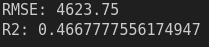

After Decoding:

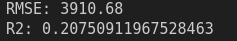

Hence, the best model with un-encoded training, is further finetuned. 

In [96]:
rf_generic_param_grid ={
    'n_estimators': [50, 100],  
    'max_depth': [None, 2, 5],   
    'min_samples_split': [1, 2, 5],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True]
}

rf_grid = GridSearchCV(
    estimator=ensemble.RandomForestRegressor(criterion='poisson'),
    param_grid=rf_generic_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train[:,2])

rf_best_params = rf_grid.best_params_

rf_best_model = ensemble.RandomForestRegressor(**rf_best_params)
rf_best_model.fit(X_train, y_train[:,2])

y_pred_in = np.round(rf_best_model.predict(X_train))
y_pred_out = np.round(rf_best_model.predict(X_test))


print(f'RMSE In Sample: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out of Sample: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')
print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')


Fitting 5 folds for each of 162 candidates, totalling 810 fits
RMSE In Sample: 445.27
RMSE Out of Sample: 4056.66
R2 In: 0.8931111884529658
R2 Out: 0.14723816675141577


In [99]:
bagging_pram_grid = {
    'n_estimators': [50, 100, 500],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True],
    'bootstrap_features': [True, False]
}

bagging_grid = GridSearchCV(
    estimator=ensemble.BaggingRegressor(),
    param_grid=bagging_pram_grid,
    scoring='neg_mean_squared_error',
    cv=30,
    n_jobs=-1,
    verbose=1
)

bagging_grid.fit(X_train, y_train[:,2])

bagging_best_params = bagging_grid.best_params_

bagging_best_model = ensemble.BaggingRegressor(**bagging_best_params)
bagging_best_model.fit(X_train, y_train[:,2])

y_pred_in = np.round(bagging_best_model.predict(X_train))
y_pred_out = np.round(bagging_best_model.predict(X_test))


print(f'RMSE In Sample: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out of Sample: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')
print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

Fitting 30 folds for each of 24 candidates, totalling 720 fits
RMSE In Sample: 726.11
RMSE Out of Sample: 3818.28
R2 In: 0.7157529092022408
R2 Out: 0.2445140663014892


In [100]:
xgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 2, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'min_child_weight': [1, 2, 5],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'gamma': [0, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],  # L2 regularization parameter
    'random_state': [42]
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor()

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train[:,2])

# Get the best parameters and model
best_params = grid_search.best_params_
xgb_best_model = grid_search.best_estimator_

# Fit the best model on the training data
xgb_best_model.fit(X_train, y_train[:,2])

y_pred_in = np.round(xgb_best_model.predict(X_train))
y_pred_out = np.round(xgb_best_model.predict(X_test))


print(f'RMSE In Sample: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out of Sample: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')
print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

RMSE In Sample: 753.93
RMSE Out of Sample: 3918.11
R2 In: 0.6935582296379301
R2 Out: 0.20449249491395582


In [ ]:
joblib.dump(rf_best_model, '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl')

['/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl']

### Success

In [ ]:
n_estimator_list = [75, 100, 500, 1000]

for n_estimators in n_estimator_list:
    balanced_rf = BalancedRandomForestClassifier(random_state=42, n_estimators=n_estimators)
    balanced_rf.fit(X_train, y_train[:,0])

    y_pred = balanced_rf.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')
    print(classification_report(y_test[:,0], y_pred))

Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.14      0.45      0.22        11
         1.0       0.92      0.70      0.79        99

    accuracy                           0.67       110
   macro avg       0.53      0.58      0.51       110
weighted avg       0.84      0.67      0.74       110

Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

         0.0       0.13      0.55      0.21        11
         1.0       0.92      0.60      0.72        99

    accuracy                           0.59       110
   macro avg       0.53      0.57      0.47       110
weighted avg       0.84      0.59      0.67       110

Accuracy: 0.6909090909090909
              precision    recall  f1-score   support

         0.0       0.21      0.73      0.32        11
         1.0       0.96      0.69      0.80        99

    accuracy                           0.69       110
   macro avg       0.58      0.71      0.

In [ ]:
n_estimator_list = [470, 475, 480, 500, 520, 525, 527, 526, 528, 529, 530, 534]

for n_estimators in n_estimator_list:
    balanced_rf = BalancedRandomForestClassifier(random_state=42, n_estimators=n_estimators)
    balanced_rf.fit(X_train, y_train[:,0])

    y_pred = balanced_rf.predict(X_test)

    print(n_estimators)
    print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')
    print(classification_report(y_test[:,0], y_pred))
    print()

470
Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.20      0.73      0.31        11
         1.0       0.96      0.67      0.79        99

    accuracy                           0.67       110
   macro avg       0.58      0.70      0.55       110
weighted avg       0.88      0.67      0.74       110


475
Accuracy: 0.7
              precision    recall  f1-score   support

         0.0       0.21      0.73      0.33        11
         1.0       0.96      0.70      0.81        99

    accuracy                           0.70       110
   macro avg       0.58      0.71      0.57       110
weighted avg       0.88      0.70      0.76       110


480
Accuracy: 0.7
              precision    recall  f1-score   support

         0.0       0.21      0.73      0.33        11
         1.0       0.96      0.70      0.81        99

    accuracy                           0.70       110
   macro avg       0.58      0.71      0.57       110
wei

In [ ]:
balanced_rf_params = {
    'n_estimators': [500,526,530,1000],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}

scores = []

for param in tqdm(ParameterGrid(balanced_rf_params)):
    easytrees = BalancedRandomForestClassifier(**param)
    easytrees.fit(X_train, y_train[:,0])

    y_pred = easytrees.predict(X_test)

    accuracy = accuracy_score(y_test[:,0], y_pred)
    precision = precision_score(y_test[:,0], y_pred)
    recall = recall_score(y_test[:,0], y_pred)
    f1 = f1_score(y_test[:,0], y_pred)
    roc_auc = roc_auc_score(y_test[:,0], y_pred)

    confusion_matrix = metrics.confusion_matrix(
        y_test[:,0], y_pred)
    
    #class_wise acc
    class_wise_acc = {}
    for i in range(2):
        class_wise_acc[i] = confusion_matrix[i][i] / sum(confusion_matrix[i])
    


    class_wise_acc_list = [class_wise_acc[i] for i in range(2)] 

    scores.append([param,
        accuracy, precision, recall, f1, roc_auc,
        ] + class_wise_acc_list)

scores_df = pd.DataFrame(scores)
scores_df.columns = ['params', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'class_0_acc', 'class_1_acc']

100%|██████████| 24/24 [00:38<00:00,  1.58s/it]


,0,1,2,3,4,5,6,7
0,"{'max_depth': None, 'max_features': None, 'min...",0.68,0.97,0.67,0.79,0.74,0.82,0.67
1,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
2,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
3,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.96,0.67,0.79,0.70,0.73,0.67
4,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.97,0.65,0.78,0.73,0.82,0.65
5,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.97,0.65,0.78,0.73,0.82,0.65
6,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.97,0.65,0.78,0.73,0.82,0.65
7,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.96,0.66,0.78,0.69,0.73,0.66
8,"{'max_depth': None, 'max_features': None, 'min...",0.65,0.97,0.63,0.76,0.72,0.82,0.63
9,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66


In [ ]:
scores_df.columns = ['params', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'class_0_acc', 'class_1_acc']
scores_df.sort_values(by=['class_0_acc', 'f1','class_1_acc'], ascending=False).head(5)

,params,accuracy,precision,recall,f1,roc_auc,class_0_acc,class_1_acc
0,"{'max_depth': None, 'max_features': None, 'min...",0.68,0.97,0.67,0.79,0.74,0.82,0.67
1,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
2,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
9,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
10,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66


In [ ]:
balanced_rf_best_params = scores_df.params[0]

balanced_rf_best = BalancedRandomForestClassifier(**balanced_rf_best_params)
balanced_rf_best.fit(X_train, y_train[:,0])


BalancedRandomForestClassifier(max_features=None, n_estimators=500,
                               random_state=42)

## Insample and outof sample tests

In [108]:
num_backers_model =  joblib.load( '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl')
collection_model = joblib.load('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/collection_ratio.pkl')
success_model = joblib.load('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/success.pkl')

In [109]:
#insample scores

y_pred = num_backers_model.predict(X_train)
print(f'RMSE: {np.sqrt(mean_squared_error(y_train[:,2], y_pred)):.3f}')

y_pred = collection_model.predict(X_train)
print(f'RMSE: {np.sqrt(mean_squared_error(y_train[:,1], y_pred)):.2f}')

y_pred = success_model.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train[:,0], y_pred)}')

RMSE: 1579.178
RMSE: 0.33
Accuracy: 0.7425968109339408


In [110]:
#out-of-sample scores

y_pred = num_backers_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.3f}')

y_pred = collection_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,1], y_pred)):.2f}')

y_pred = success_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')

RMSE: 4623.755
RMSE: 1.74
Accuracy: 0.6818181818181818
